# Workshop: Object Detection with Hugging Face, Ultralytics YOLOv8, and Lightning

In this workshop we will explore three approaches for object detection using PyTorch:

1. **Inference with Hugging Face DETR:** Using a pre-trained DETR model via a pipeline.
2. **Inference & Training with Ultralytics YOLOv8:** Running inference and training a YOLO model on your own dataset (requires a YOLO-formatted dataset and a `data.yaml` configuration file).
3. **Training Faster‑R‑CNN with PyTorch Lightning:** Wrapping a TorchVision Faster‑R‑CNN model in a LightningModule and training it on the PennFudanPed dataset, with data augmentation via TorchVision Transforms v2.

Follow along for hands-on experience!

## Installation

Install the required packages by running the cell below.

In [1]:
 !pip install -U transformers pillow matplotlib ultralytics timm lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 923.8/923.8 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Organize Imports

In [2]:
import os
import gc

In [3]:
import requests, zipfile, io
from pathlib import Path

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import requests
from PIL import Image
from IPython.display import display

In [7]:
import torch
from torch.utils.data import DataLoader, random_split

In [8]:
import torchvision
# Use TorchVision Transforms v2 for data augmentation
from torchvision.transforms import v2 as T2
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

In [9]:
from transformers import pipeline

In [10]:
import lightning as pl

In [11]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Initialize Device

In [12]:
def init_device():
    # For the most part I'll try to import functions and classes near
    # where they are used
    # to make it clear where they come from.
    if torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f'Device: {device}')

    return device

In [13]:
device = init_device()
device

Device: cuda


'cuda'

## Initialize Paths

In [14]:
PATH = Path('data')
africanw = PATH / 'africanw' / 'african-wildlife.yaml'
pennfped = PATH / 'PennFudanPed' / 'PennFudanPed'
models_path = PATH / 'models'
models_path.mkdir(exist_ok=True, parents=True)

In [15]:
pennfped.parent

PosixPath('data/PennFudanPed')

In [16]:
! ls {pennfped}

ls: cannot access 'data/PennFudanPed/PennFudanPed': No such file or directory


In [17]:
africanw

PosixPath('data/africanw/african-wildlife.yaml')

## Download Datasets

In [18]:
# URL for the PennFudanPed dataset zip file
url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"

if pennfped.exists():
    print('Data folder exists')
else:
    print("Downloading PennFudanPed dataset...")
    r = requests.get(url)
    if r.status_code == 200:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(pennfped.parent)
        print("Downloaded and extracted PennFudanPed dataset to './PennFudanPed'")
    else:
        print("Download failed with status code:", r.status_code)

Downloaded and extracted PennFudanPed dataset to './PennFudanPed'


## Part 1: Inference with Hugging Face DETR

In this section we load a pre-trained DETR model via Hugging Face’s pipeline and run inference on a sample image.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


DETR Inference Results:
{'score': 0.8563560843467712, 'label': 'tie', 'box': {'xmin': 278, 'ymin': 475, 'xmax': 296, 'ymax': 527}}
{'score': 0.9989952445030212, 'label': 'person', 'box': {'xmin': 221, 'ymin': 405, 'xmax': 343, 'ymax': 858}}
{'score': 0.5202415585517883, 'label': 'fire hydrant', 'box': {'xmin': 657, 'ymin': 622, 'xmax': 691, 'ymax': 714}}
{'score': 0.9993982315063477, 'label': 'person', 'box': {'xmin': 668, 'ymin': 394, 'xmax': 809, 'ymax': 886}}
{'score': 0.9862419366836548, 'label': 'person', 'box': {'xmin': 0, 'ymin': 556, 'xmax': 74, 'ymax': 880}}
{'score': 0.7995827198028564, 'label': 'cell phone', 'box': {'xmin': 238, 'ymin': 503, 'xmax': 257, 'ymax': 524}}
{'score': 0.9996187686920166, 'label': 'person', 'box': {'xmin': 55, 'ymin': 398, 'xmax': 243, 'ymax': 905}}
{'score': 0.9995725750923157, 'label': 'bus', 'box': {'xmin': 33, 'ymin': 230, 'xmax': 805, 'ymax': 738}}


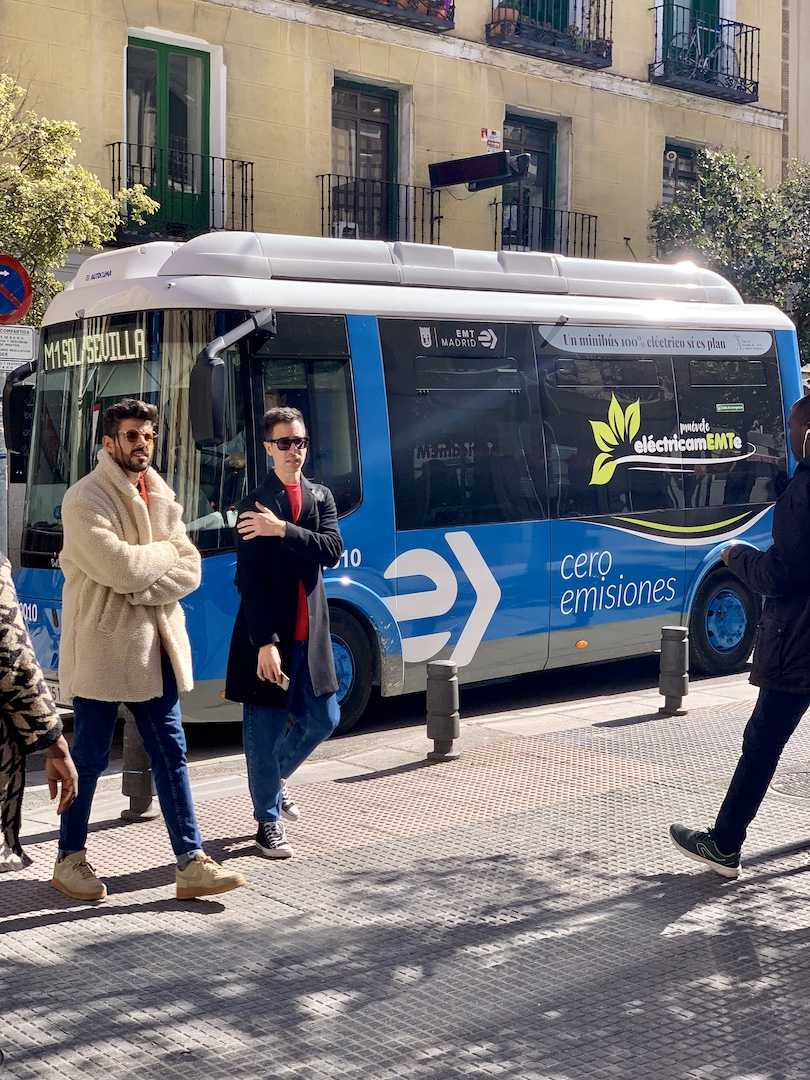

In [19]:
# Download a sample image
url = "https://ultralytics.com/images/bus.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Initialize the Hugging Face object detection pipeline (using DETR)
detr_detector = pipeline("object-detection", model="facebook/detr-resnet-50")

# Run inference
results = detr_detector(image)

print("DETR Inference Results:")
for r in results:
    print(r)

display(image)

## Part 2: Inference with Ultralytics YOLOv8

Next, we use Ultralytics YOLOv8 to run inference on the same sample image.

100%|██████████| 6.25M/6.25M [00:00<00:00, 98.9MB/s]


100%|██████████| 134k/134k [00:00<00:00, 10.3MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 97.1ms
Speed: 14.7ms preprocess, 97.1ms inference, 236.5ms postprocess per image at shape (1, 3, 640, 480)


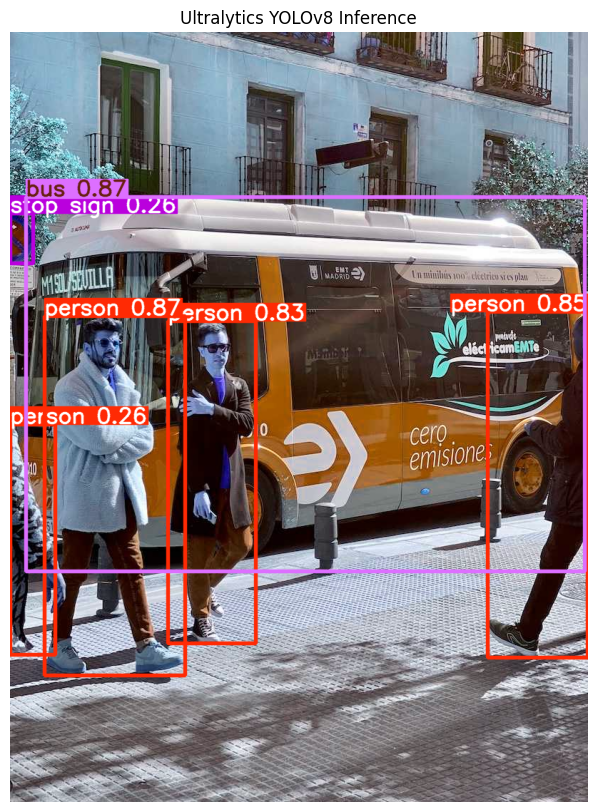

In [20]:
# Load the pre-trained YOLOv8 nano model
yolo_model = YOLO("yolov8n.pt")

# Run inference on the sample image
results_yolo = yolo_model("https://ultralytics.com/images/bus.jpg")

# Print YOLOv8 results
# print(results_yolo)

# Plot the image with predictions
plt.figure(figsize=(10, 10))
plt.imshow(results_yolo[0].plot())
plt.axis('off')
plt.title('Ultralytics YOLOv8 Inference')
plt.show()

## Part 3: Training with Ultralytics YOLOv8

To train a YOLO model using Ultralytics, you need a dataset in YOLO format along with a YAML configuration file (e.g., `data/my_dataset/data.yaml`).

For example, your `data.yaml` might look like:

```yaml
train: data/my_dataset/images/train
val: data/my_dataset/images/val
nc: 2
names: ['class1', 'class2']
```

Make sure that the file exists at the specified path. Then run the cell below to start training for 5 epochs.

In [21]:
# Initialize the YOLOv8 nano model with pre-trained weights
yolov8n = YOLO('yolov8n.pt')

In [22]:
yolov8n = yolov8n.to(device)

In [29]:
africanw.parent.mkdir(exist_ok=True, parents=True)

url = "https://raw.githubusercontent.com/ultralytics/ultralytics/refs/heads/main/ultralytics/cfg/datasets/african-wildlife.yaml"
response = requests.get(url)

if response.status_code == 200:
    with africanw.open(mode="w") as f:
        f.write(response.text)
    print("File downloaded successfully as 'african-wildlife.yaml'!")
else:
    print("Failed to download file. Status code:", response.status_code)

File downloaded successfully as 'african-wildlife.yaml'!


In [30]:
yolov8n.train(
    data=africanw,
    epochs=5,
    imgsz=640,
    device=device,
    workers=8
)

Ultralytics 8.3.87 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data/africanw/african-wildlife.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 100M/100M [00:01<00:00, 89.6MB/s]
Unzipping /content/datasets/african-wildlife.zip to /content/datasets/african-wildlife...: 100%|██████████| 3008/3008 [00:00<00:00, 3525.16file/s]

Dataset download success ✅ (2.9s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 25.4MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 107MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context:

AMP: checks passed ✅


train: Scanning /content/datasets/african-wildlife/train/labels... 1052 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1052/1052 [00:00<00:00, 2338.01it/s]

train: New cache created: /content/datasets/african-wildlife/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/african-wildlife/valid/labels... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:00<00:00, 1205.59it/s]


val: New cache created: /content/datasets/african-wildlife/valid/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        1/5      2.39G     0.8488      2.258      1.226         66        640: 100%|██████████| 66/66 [00:22<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      

                   all        225        379      0.631      0.527      0.602       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        2/5      2.89G     0.8671      1.473      1.224         77        640: 100%|██████████| 66/66 [00:24<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      

                   all        225        379      0.671      0.727      0.798      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        3/5      2.89G      0.887      1.345      1.238         64        640: 100%|██████████| 66/66 [00:20<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      

                   all        225        379      0.848      0.707      0.836       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        4/5      2.89G     0.8189        1.2      1.183         52        640: 100%|██████████| 66/66 [00:19<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      

                   all        225        379      0.888       0.79        0.9        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:201: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
        5/5       2.9G     0.7501      1.083      1.146         49        640: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      

                   all        225        379      0.857      0.846      0.911       0.72



5 epochs completed in 0.034 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.87 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operati

                   all        225        379      0.857      0.846      0.911       0.72
               buffalo         62         89      0.932      0.768      0.899      0.717
              elephant         53         91      0.769      0.842      0.876      0.679
                 rhino         55         85      0.863      0.882      0.926      0.771
                 zebra         59        114      0.864      0.891      0.942      0.712
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c1864215ad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [31]:
yolov8n.save(models_path / 'yolov8n_afrwld.pt')

In [32]:
yolov8n.export(format='onnx')

Ultralytics 8.3.87 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...


ONNX: starting export with onnx 1.17.0 opset 19...


KeyboardInterrupt: 

## Part 4: Training Faster‑R‑CNN with PyTorch Lightning and TorchVision Transforms v2

In this section we train a Faster‑R‑CNN model on the PennFudanPed dataset using PyTorch Lightning. We use a new data augmentation pipeline built with TorchVision Transforms v2. Make sure the PennFudanPed dataset is downloaded and extracted into a folder named `PennFudanPed`.

The data augmentation pipeline includes random resized cropping, horizontal flipping, and color jitter. These augmentations help improve model robustness.

In [33]:
gc.collect()

60335

#### Initialize Transforms for Data Augmentations

In [34]:
def get_transform(train: bool):
    if train:
        return T2.Compose([
            T2.RandomResizedCrop(size=(300, 300)),
            T2.RandomHorizontalFlip(p=0.5),
            T2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            T2.ToTensor(),
            T2.ConvertImageDtype(torch.float),
            T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return T2.Compose([
            T2.Resize((300, 300)),
            T2.ToTensor(),
            T2.ConvertImageDtype(torch.float),
            T2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Minimal collate function for variable number of targets per image
def collate_fn(batch):
    return tuple(zip(*batch))

#### Initialize Dataset

In [35]:
# Define the PennFudanPed Dataset (adapted from TorchVision tutorials)
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Instances are encoded as different colors
        obj_ids = np.unique(mask)[1:]
        masks = mask == obj_ids[:, None, None]

        boxes = []
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = len(obj_ids)
        labels = torch.ones((num_objs,), dtype=torch.int64)  # one class: person

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [36]:
# Prepare the dataset using the new transforms v2
dataset_full = PennFudanDataset(pennfped.absolute(), get_transform(train=True))
n = len(dataset_full)
n_train = int(0.8 * n)
n_val = n - n_train
dataset_train, dataset_val = random_split(dataset_full, [n_train, n_val])

workers = 0

train_loader = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
    num_workers=workers,
    # persistent_workers=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    dataset_val,
    batch_size=4,
    shuffle=False,
    num_workers=workers,
    # persistent_workers=True,
    collate_fn=collate_fn
)

#### Initialize the Model

In [49]:
# Define a PyTorch Lightning Module for Faster-RCNN
class FasterRCNNLightning(pl.LightningModule):
    def __init__(self, num_classes=2, lr=0.005):
        super().__init__()
        # Load pre-trained Faster-RCNN model
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights=torchvision.models.detection.faster_rcnn.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        )
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        self.lr = lr

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        images = [img.to(self.device) for img in images]
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        images = [img.to(self.device) for img in images]
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9, weight_decay=0.0005)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        return [optimizer], [scheduler]

#### Train the Model

In [50]:
# Instantiate the Lightning module
model_lightning = FasterRCNNLightning(num_classes=2)

In [51]:
# Initialize a PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=2,
    accelerator='auto',
    devices=1
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [52]:
gc.collect()

3506

In [53]:
# Train the Faster-RCNN model
trainer.fit(
    model_lightning,
    train_loader,
    val_loader
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [-1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [-1]
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 41.3 M | train
---------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 41.3 M | train
---------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

## Visualize the Results

In [ ]:
batch = next(iter(val_loader))

In [ ]:
# Ensure the underlying TorchVision model is in eval mode
model_lightning.model.eval()

# Define mean and std used during training (for un-normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(img):
    """Reverse the normalization on an image tensor."""
    return img * std + mean

# Get a batch from the validation DataLoader (val_loader from training section)
batch = next(iter(val_loader))
images, targets = batch
# Move images to device (assumed same device as model)
images = [img.to(model_lightning.device) for img in images]

# Run inference (without gradients)
with torch.no_grad():
    outputs = model_lightning.model(images)

# Loop over each image in the batch and plot predictions
for i, img in enumerate(images):
    # Unnormalize the image for visualization
    img_unnorm = unnormalize(img).clamp(0, 1)
    # Convert tensor to uint8 for drawing
    img_uint8 = (img_unnorm * 255).type(torch.uint8)

    # Get predictions for the image and filter by confidence threshold (e.g., 0.5)
    boxes = outputs[i]["boxes"].detach().cpu()
    scores = outputs[i]["scores"].detach().cpu()
    keep = scores >= 0.5
    boxes = boxes[keep]

    # Draw boxes on the image
    drawn_img = draw_bounding_boxes(img_uint8, boxes, colors="red", width=2)

    # Convert to PIL image and display
    plt.figure(figsize=(8, 8))
    plt.imshow(F.to_pil_image(drawn_img))
    plt.title(f"Validation Image {i} Predictions")
    plt.axis("off")
    plt.show()

## Conclusion

In this notebook we demonstrated:

- **Inference with Hugging Face DETR:** Running inference on a sample image using a DETR model via Transformers.
- **Inference & Training with Ultralytics YOLOv8:** Running inference on a sample image and training a YOLO model using Ultralytics (ensure your dataset YAML file exists at the specified path).
- **Training Faster‑R‑CNN with PyTorch Lightning:** Wrapping TorchVision’s Faster‑R‑CNN in a LightningModule, using TorchVision Transforms v2 for data augmentation on the PennFudanPed dataset, and training the model.

Feel free to experiment further with hyperparameters, dataset splits, and alternative models. Happy detecting and training!

In [ ]:
# Ensure the underlying TorchVision model is in eval mode
model_lightning.model.eval()

# Define mean and std used during training (for un-normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(img):
    """Reverse the normalization on an image tensor."""
    return img * std + mean

# Get a batch from the validation DataLoader (val_loader from training section)
batch = next(iter(val_loader))
images, targets = batch
# Move images to device (assumed same device as model)
images = [img.to(model_lightning.device) for img in images]

# Run inference (without gradients)
with torch.no_grad():
    outputs = model_lightning.model(images)

# Loop over each image in the batch and plot predictions
for i, img in enumerate(images):
    # Unnormalize the image for visualization
    img_unnorm = unnormalize(img).clamp(0, 1)
    # Convert tensor to uint8 for drawing
    img_uint8 = (img_unnorm * 255).type(torch.uint8)

    # Get predictions for the image and filter by confidence threshold (e.g., 0.5)
    boxes = outputs[i]["boxes"].detach().cpu()
    scores = outputs[i]["scores"].detach().cpu()
    keep = scores >= 0.5
    boxes = boxes[keep]

    # Draw boxes on the image
    drawn_img = draw_bounding_boxes(img_uint8, boxes, colors="red", width=2)

    # Convert to PIL image and display
    plt.figure(figsize=(8, 8))
    plt.imshow(F.to_pil_image(drawn_img))
    plt.title(f"Validation Image {i} Predictions")
    plt.axis("off")
    plt.show()